### Imports

In [1]:
import csv
import re
import glob
import datetime
from pathlib import Path
import pandas
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append(str(Path.cwd().parents[1]))
from functions import *

### Set Save File Name

In [2]:
save_path = Path.cwd() / "Plots"
if not save_path.exists():
    save_path.mkdir()

### Get the Data Paths

In [3]:
# Get the lists of file paths
jump_combined = getFilePaths(Path.cwd(), header="Select the File", verbose=True)

In [4]:
# Get the list of dataframes from the lists of file paths
jc_dfs = readCSVFiles(jump_combined)

### Average the data in Data Paths

In [5]:
# get the list of average and std for all the dataframes
unique_headers = ['Time', 'Reward', 'Input', 'RodPos', 'RodVel', 'ActPos',
       'ActVel']

jc_dfs_parsed = []
for df in jc_dfs:
    jc_dfs_parsed.append(parseDataFrame(df, unique_headers))

In [6]:
# remove all the agents who never got off the ground
for agent_type in jc_dfs_parsed:
    for column in agent_type["RodPos"]:
        if np.max(agent_type["RodPos"][column]) < 0:
            # get index of series within the dataframe
            index = agent_type["RodPos"].columns.get_loc(column)
            # get index of agent
            agent_index = jc_dfs_parsed.index(agent_type)
            print(agent_index, index)
            # remove the series from all dataframes
            for df in jc_dfs_parsed[agent_index]:
                jc_dfs_parsed[agent_index][df].drop(agent_type[df].columns[index], axis=1, inplace=True)


0 18


### Plot Average/STD Timeseries

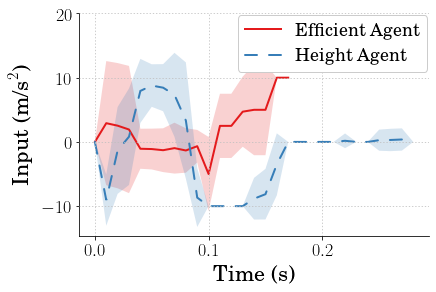

In [14]:
jump_type = 'One'
plot_type = 'Input'

X_EFF_MEAN, X_EFF_STD = dfAverageStd(jc_dfs_parsed[0]["Time"])
Y_EFF_MEAN, Y_EFF_STD = dfAverageStd(jc_dfs_parsed[0][plot_type])

X_HEI_MEAN, X_HEI_STD = dfAverageStd(jc_dfs_parsed[1]["Time"])
Y_HEI_MEAN, Y_HEI_STD = dfAverageStd(jc_dfs_parsed[1][plot_type])

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

# Define the X and Y axis labels
plt.xlabel(r'Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel(r"Input ($\textup{m/s}^2$)", fontsize=22, weight='bold', labelpad=10)
# plt.ylabel(r"Height (m)", fontsize=22, weight='bold', labelpad=10)

plt.plot(X_EFF_MEAN, Y_EFF_MEAN, linewidth=2, linestyle='-', label="Efficient Agent")
plt.fill_between(X_EFF_MEAN, Y_EFF_MEAN-Y_EFF_STD, Y_EFF_MEAN+Y_EFF_STD, alpha=0.2)
plt.plot(X_HEI_MEAN, Y_HEI_MEAN, linewidth=2, linestyle='--', label="Height Agent")
plt.fill_between(X_HEI_MEAN, Y_HEI_MEAN-Y_HEI_STD, Y_HEI_MEAN+Y_HEI_STD, alpha=0.2)
        
# uncomment below and set limits if needed
# plt.xlim(0,1.25)
plt.ylim(bottom=None, top=20)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# filename = save_path / f'avg_{jump_type}_{plot_type}_.svg'
# plt.savefig(filename, transparent=True)
# filename = save_path / f'avg_{jump_type}_{plot_type}_.png'
# plt.savefig(filename, transparent=True)
plt.show()

### Find the Best Agents

In [15]:
max_rew = 0
agents = []
agent_indices = []
for jump_type in jc_dfs_parsed:
    for column in jump_type["Reward"]:
        if np.max(jump_type["Reward"][column]) > max_rew:
            max_rew = np.max(jump_type["Reward"][column])
            agent_col = column
            # get the index of the agent
            agent_index = jump_type["Reward"].columns.get_loc(agent_col)
    agents.append(agent_col)
    agent_indices.append(agent_index)

### Plot Best Agents

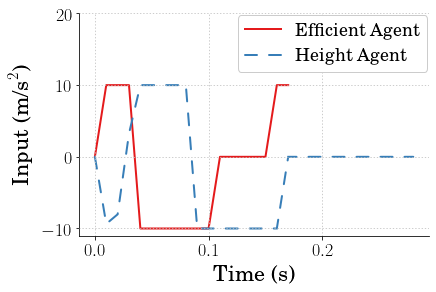

In [21]:
jump_type = 'One'
plot_type = 'Input'

Y_EFF = jc_dfs_parsed[0][plot_type].iloc[:, agent_indices[0]]
X_EFF = jc_dfs_parsed[0]["Time"].iloc[:, agent_indices[0]]

Y_HEI = jc_dfs_parsed[1][plot_type].iloc[:, agent_indices[1]]
X_HEI = jc_dfs_parsed[1]["Time"].iloc[:, agent_indices[1]]

# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

# Define the X and Y axis labels
plt.xlabel(r'Time (s)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel(r"Input ($\textup{m/s}^2$)", fontsize=22, weight='bold', labelpad=10)
# plt.ylabel(r"Height (m)", fontsize=22, weight='bold', labelpad=10)

plt.plot(X_EFF, Y_EFF, linewidth=2, linestyle='-', label="Efficient Agent")
plt.plot(X_HEI, Y_HEI, linewidth=2, linestyle='--', label="Height Agent")
        
# uncomment below and set limits if needed
# plt.xlim(0,1.25)
plt.ylim(bottom=None, top=20)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# filename = save_path / f'best_{jump_type}_{plot_type}_.svg'
# plt.savefig(filename, transparent=True)
# filename = save_path / f'best_{jump_type}_{plot_type}_.png'
# plt.savefig(filename, transparent=True)
plt.show()

### Create Max Height and Power Used Data

In [22]:
heights_combined = []

for agent_type in jc_dfs_parsed:
    heights = []
    for column in agent_type["RodPos"]:
        max_h = np.max(agent_type["RodPos"][column])
        heights.append(max_h)
    heights_combined.append(heights)

powers_combined = []
for agent_type in jc_dfs_parsed:
    acc = agent_type["Input"]
    vel = agent_type["ActVel"]
    mass = 1.003
    power = acc.to_numpy() * vel.to_numpy() * mass
    # sum power along the columns
    power_summed = np.nansum(power, axis=0)
    powers_combined.append(np.abs(power_summed))

### Plot the Height vs Power Used Scatter Plot

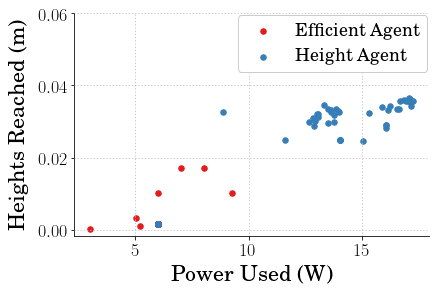

In [25]:
# Create a scatter plot of the heights and power used
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6,4))
ax = plt.gca()

# Define the X and Y axis labels
plt.xlabel(r'Power Used (W)', fontsize=22, weight='bold', labelpad=5)
plt.ylabel(r"Heights Reached (m)", fontsize=22, weight='bold', labelpad=10)

# plot the data
plt.scatter(powers_combined[0], heights_combined[0], label="Efficient Agent", s=30)
plt.scatter(powers_combined[1], heights_combined[1], label="Height Agent", s=30)

# uncomment below and set limits if needed
# plt.xlim(0,8)
plt.ylim(bottom=None, top=0.06)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, fontsize=18)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# save the figure as a high-res pdf in the current folder
# filename = save_path / 'One_HeightVsPower.svg'
# plt.savefig(filename, transparent=True)
# filename = save_path / 'One_HeightVsPower.png'
# plt.savefig(filename, transparent=True)
plt.show()